In [1]:
import sys
sys.path.append('..')
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from plotting import tsplot, tsplot_boot,show_landmark_and_platform
from tqdm import tqdm_notebook as tqdm
import random

In [2]:
from environments import WaterMazeEnv
from combined_agent import TDAgent as Agent
from datetime import datetime
import os 
from multiprocessing import Pool
from functools import partial
output_path = 'figures/'

Loaded reward traces from file.
Loaded reward traces from file.
Loaded reward traces from file.


In [3]:
def get_platform_and_landmark_locations(env, number=9):
    angles = np.linspace(0, 2*np.pi, number)
    r = env.maze_radius / 2
    platform_locations = [[r * np.cos(a), r * np.sin(a)] for a in angles]
    landmark_locations = [[r * np.cos(a), r * np.sin(a)+.1] for a in angles]
    platform_locations = env.maze_centre + platform_locations
    landmark_locations = env.maze_centre + landmark_locations
    return platform_locations, landmark_locations

envi = WaterMazeEnv()
platform_locations, landmark_locations = get_platform_and_landmark_locations(envi)


In [4]:
ag = Agent(env=envi,lesion_hippocampus=False)

In [5]:
n_simulations = 30
n_episodes = 15


    
def run_one_agent(i, hc_pos=.04, hc_neg=.03, striat=.03, lambd=.67, zeta=3.5):
    escape_times = np.zeros(n_episodes)
    ag = Agent(env=envi,lesion_striatum=False, lesion_hippocampus=False)
    ag.zeta= zeta
    ag.hippocampus.learning_rate = hc_pos
    ag.hippocampus.negative_learning_rate = hc_neg
    ag.striatum.learning_rate = striat
    ag.striatum.lamb = lambd
    ag.striatum.weight_mat = random_weights[i]
    for ep in range(n_episodes):
        
        if ep == 0: 
            envi.set_platform_and_landmark(platform_locations[0], landmark_locations[0])

        if ep == 7: 
            envi.set_platform_and_landmark(platform_locations[4], landmark_locations[4])

        t, reward, locs, choices = ag.train_one_episode()
        escape_times[ep] = t
    return escape_times

In [6]:
#fig, ax = plt.subplots()
#tsplot_boot(ax, np.array(ets))

In [60]:
# Do the same thing with multiprocessing


# Random weight initialisations

def get_random_weights():
    w = np.random.rand(ag.striatum.n_action_cells, ag.striatum.n_landmark_cells) * .008
    return w

random_weights = [get_random_weights() for w in range(n_simulations)]

In [8]:
p = Pool(30)

In [9]:
results = np.array(p.map(run_one_agent, list(range(n_simulations))))

(0, 1200)

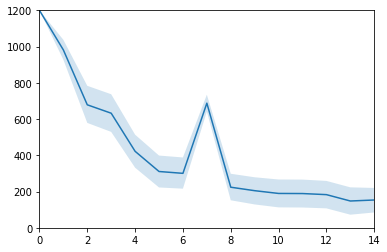

In [11]:
fig, ax = plt.subplots()
tsplot_boot(ax, np.array(results))
plt.ylim([0,1200])

In [ ]:
# Pearce task

In [12]:
n_sims = 30
n_trials = 4
n_sessions = 12

escape_times = np.zeros((n_sims, n_sessions, n_trials))
session_ids = list(range(len(platform_locations)))
sessions = [np.random.choice(session_ids) for _ in range(n_sessions)]

sessions = [0, 4, 1, 5, 2, 6, 3, 7, 4, 8, 3, 0]

first_trials_control_trajectory=[]



In [13]:
def run_pearce_task(i, hc_pos=.04, hc_neg=.03, striat=.03, lambd=.67, zeta=3.5, epsilon=.13, lesion_hippocampus=False):
    escape_times = np.zeros((n_sessions, n_trials))
    
    ag = Agent(env=envi, lesion_striatum=False, lesion_hippocampus=lesion_hippocampus)
    ag.zeta= zeta
    ag.hippocampus.learning_rate = hc_pos
    ag.hippocampus.negative_learning_rate = hc_neg
    ag.striatum.learning_rate = striat
    ag.striatum.lamb = lambd
    ag.striatum.weight_mat = random_weights[i]
    ag.epsilon=epsilon
    
    for sess_n, session in enumerate(sessions):
        envi.set_platform_and_landmark(platform_locations[session], landmark_locations[session])
        for trial in range(n_trials):
            t, reward, locs, choices = ag.train_one_episode()
            if trial == 0:
                first_trials_control_trajectory.append(locs)
            escape_times[sess_n, trial] = t
    return escape_times


In [54]:
p = Pool(30)


In [91]:
zeta = .9  # Higher is more striatum choices
hc_pos = .07
hc_neg = .2
striat = .003
lambd = .67
epsilon = .13

results_nolesion = p.map(partial(run_pearce_task, 
                                 zeta=zeta, 
                                 hc_pos=hc_pos, 
                                 hc_neg=hc_neg,
                                 striat=striat,
                                 lambd=lambd,
                                 epsilon=epsilon), list(range(n_sims)))

In [92]:
results_lesion = p.map(partial(run_pearce_task, 
                               lesion_hippocampus=True,
                                 zeta=zeta, 
                                 hc_pos=hc_pos, 
                                 hc_neg=hc_neg,
                                 striat=striat,
                                 lambd=lambd,
                                 epsilon=epsilon), list(range(n_sims)))

In [93]:
escape_times = np.array(results_nolesion)
escape_times_lesion = np.array(results_lesion)

In [94]:
time_step = 1

first_trials = escape_times[:,:,0].mean(axis=0) * time_step
fourth_trials = escape_times[:,:,1].mean(axis=0)* time_step

first_trials_lesion = escape_times_lesion[:,:,0].mean(axis=0) * time_step
fourth_trials_lesion = escape_times_lesion[:,:,1].mean(axis=0) * time_step


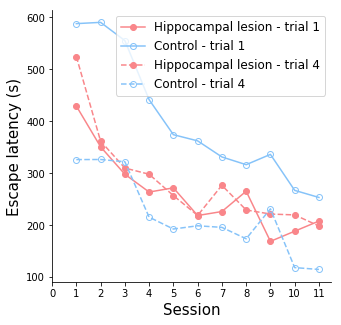

In [95]:
fig, ax = plt.subplots(figsize=(5,5))
red = '#f9868a'
blue = '#86c3f9'


plt.plot(np.arange(1,12), first_trials_lesion[:-1], 'o-', color=red)
plt.plot(np.arange(1,12), first_trials[:-1], 'o-', fillstyle='none', color=blue)
plt.plot(np.arange(1,12), fourth_trials_lesion[:-1], 'o--', color=red)
plt.plot(np.arange(1,12), fourth_trials[:-1], 'o--', fillstyle='none', color=blue)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.ylim([0,122])
plt.ylabel('Escape latency (s)', fontsize=15)
plt.xlabel('Session', fontsize=15)

plt.legend(['Hippocampal lesion - trial 1', 'Control - trial 1', 
            'Hippocampal lesion - trial 4', 'Control - trial 4'], fontsize=12)

plt.xticks(np.arange(0, 12))

if not os.path.isdir(output_path):
    os.makedirs(output_path)

plt.savefig(os.path.join(output_path,'PearceModel-ClearLegend.svg'))

plt.show()

In [30]:
zeta = 1.3  # Higher is more striatum choices
hc_pos = .2
hc_neg = .1
striat = .03
lambd = .67
epsilon = .13


In [31]:
zetas = np.linspace(.5, 3, 10)
hc_plus = np.linspace(.5, 3, 10)

In [32]:
params_grid = {}
params_grid['zetas'] = np.linspace(.5, 3, 10)
params_grid['hc_pos'] = np.linspace(.01, .3, 10)
params_grid['hc_neg'] = np.linspace(.01, .3, 10)
params_grid['striat'] = np.linspace(.01, .3, 10)
params_grid['lambda'] = np.linspace(.5, 8, 5)
params_grid['epsilon'] = np.linspace(.05, .15, 3)

In [ ]:
for zeta in params_grid['zetas']:
    for hc_pos in params_grid['hc_pos']:
        for hc_neg in params_grid['hc_neg']:
            for striat in params_grid['striat']:
                for lambd in params_grid['lambda']:
                    for epsilon in params_grid['epsilon']:
                        